<a href="https://colab.research.google.com/github/siddhant-uniyal/NLP/blob/main/Tranformer_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing all the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from tensorflow.keras.layers import Attention, Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from tensorflow.python.keras import backend as K
import gc
en_stopwords = stopwords.words('english')
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Global Variables

In [ ]:
max_len_text=80
max_len_summary=10
epochs=10
number_of_datapoints=100000

logger = tf.get_logger()

In [ ]:
data=pd.read_csv("/content/gdrive/MyDrive/Reviews.csv")

In [ ]:
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if not better than resturants I have eaten at..My husband loved it..will find other recipes to use this in..
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,"I'm disappointed with the flavor. The chocolate notes are especially weak. Milk thickens it but the flavor still disappoints. This was worth a try but I'll never buy again. I will use what's left,..."
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 of those in one training session. I tried to train our dog with ""Ceaser dog treats"", it just made our puppy hyper. If you compare the ingredients, y..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rewarding your dog for being good while grooming. Lower in calories and loved by all the doggies. Sweet potatoes seem to be their favorite Wet Noses tr...


In [ ]:
data = data[:number_of_datapoints].reset_index()

In [ ]:
# from stack overflow
contraction_mapping = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
    "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
    "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
    "she'll've": "she will have", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "so's": "so as", "this's": "this is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
    "you'll've": "you will have", "you're": "you are", "you've": "you have"
}
contractions = list(contraction_mapping.keys())
sources = list(contraction_mapping.values())
max_source_len , min_source_len = max(len(source.split()) for source in sources) , min(len(source.split()) for source in sources)
windows = np.arange(max_source_len , min_source_len -1 , -1)

### Utility Data Preprocessing functions

In [ ]:
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)' , ' ' , newString)#first remove all text within parentheses including parentheses themselves
    newString = re.sub(r'"' , ' ' , newString) #second remove all " and replace with space
    words = newString.split() # check if contractions can be made , if yes , make them
    for window in windows:
      for i in range(len(words)-window+1):
        curr_sources = ' '.join(words[i:i+window])
        try:
          position = sources.index(curr_sources)
        except:
          position = None
        if position:
          words[i] = contractions[position]
          del words[i+1:i+window]
    newString = ' '.join(words)
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub(r"[^a-zA-Z]", " ", newString)
    tokens = [word for word in newString.split() if word not in en_stopwords]
    long_words=[]
    for token in tokens:
        if len(token) >= 3:
          long_words.append(token)
    return (" ".join(long_words)).strip()

In [ ]:
def summary_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'"' , ' ' , newString) #first remove all " and replace with space
    words = newString.split() # check if contractions can be made , if yes , make them
    windows = np.arange(min_source_len , max_source_len + 1)
    for window in windows:
      for i in range(len(words)-window+1):
        curr_sources = ' '.join(words[i:i+window])
        try:
          position = sources.index(curr_sources)
        except:
          position = None
        if position:
          words[i] = contractions[position]
          del words[i+1:i+window]
    newString = ' '.join(words)
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

### Data Preprocessing

In [ ]:
data.info()
data.drop_duplicates(inplace = True)
data.dropna(inplace = True)
data.info()
number_of_datapoints = data.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   index                   100000 non-null  int64 
 1   Id                      100000 non-null  int64 
 2   ProductId               100000 non-null  object
 3   UserId                  100000 non-null  object
 4   ProfileName             99994 non-null   object
 5   HelpfulnessNumerator    100000 non-null  int64 
 6   HelpfulnessDenominator  100000 non-null  int64 
 7   Score                   100000 non-null  int64 
 8   Time                    100000 non-null  int64 
 9   Summary                 99998 non-null   object
 10  Text                    100000 non-null  object
dtypes: int64(6), object(5)
memory usage: 8.4+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 99992 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dt

In [ ]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [ ]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

data = data[data["cleaned_summary"] != ""]
number_of_datapoints = data.shape[0]

In [ ]:
data['cleaned_summary'] = list(map(lambda x : f"_START_ {x} _END_" , data['cleaned_summary']))

In [ ]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

### Analysis of Sentence and Summary Length

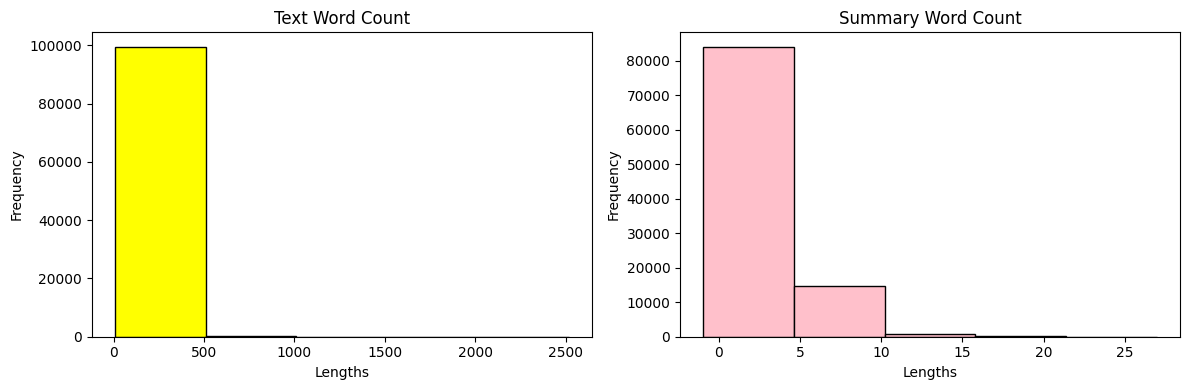

In [ ]:
text_word_count = []
summary_word_count = []

for text in data['Text']:
  text_word_count.append(len(text.split()))

for summary in data['Summary']:
  summary_word_count.append(len(summary.split()) - 2)

max_len_summary = max(summary_word_count) + 2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].hist(text_word_count, bins=5, color='Yellow', edgecolor='black')
axes[0].set_title('Text Word Count')

axes[1].hist(summary_word_count, bins=5, color='Pink', edgecolor='black')
axes[1].set_title('Summary Word Count')

for ax in axes:
    ax.set_xlabel('Lengths')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Train-Test Split

In [ ]:
tokenizer_x = Tokenizer()
tokenizer_x.fit_on_texts(data['cleaned_text'])

tokenizer_y = Tokenizer()
tokenizer_y.fit_on_texts(data['cleaned_summary'])

data['cleaned_text_encoded'] = tokenizer_x.texts_to_sequences(data['cleaned_text'])
data['cleaned_summary_encoded'] = tokenizer_y.texts_to_sequences(data['cleaned_summary'])


In [ ]:
data = data[data['cleaned_text_encoded'].apply(lambda x: len(x) <= max_len_text)]

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text_encoded'],data['cleaned_summary_encoded'],test_size=0.1,random_state=0,shuffle=True)

In [ ]:
x_tr = np.array(pad_sequences(x_tr , padding = "pre" , maxlen = max_len_text))
x_val = np.array(pad_sequences(x_val , padding = "pre" , maxlen = max_len_text))

x_voc_size = len(tokenizer_x.word_index) + 1

In [ ]:
x_tr[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 1211,  514, 5477,   57,
          4,    3,  800], dtype=int32)

In [ ]:
y_tr = np.array(pad_sequences(y_tr , padding = "pre" , maxlen = max_len_summary))
y_val = np.array(pad_sequences(y_val , padding = "pre" , maxlen = max_len_summary))

y_voc_size = len(tokenizer_y.word_index) + 1

number_of_datapoints = data.shape[0]

number_of_datapoints #number of timestamps

91027

## Architecture

In [ ]:
tf.keras.backend.clear_session()

embed_dim = 500 #every word goes from 80d vector to 500d vector
encoder_lstm_units = 512
decoder_lstm_units = 512 # we are using 512 units in all 3 LSTM layers of encoder and single LSTM layer of decoder

#first step : taking input of sequences , each of shape : (80,)
encoder_inputs = Input(shape=(max_len_text,))

#second step : getting embeddings of each word from the lookup table
enc_emb = Embedding(x_voc_size, embed_dim, trainable=True)(encoder_inputs)

#third step : encoding

#encoder architecture:
#3 lstm layers stacked on each other. output of one is the input of other , so each output is better than the last
#note : return_sequences = True , gives hidden state output of each timestep. hence this is needed for encoder
# return_state = True , gives only hidden state output and cell state output at last timestep. so this is also needed to initialize decoder , although only in the last layer of the LSTM stack.

#shapes:
#number of timesteps = number of datapoints = number of words in the sentence provided = 80 (max_len_text)
#number of features = dimensionality of each word = 512 (embedding dim , which we specified above)
#number of samples = 1 (one sentence at a time)
#hence input of each lstm layer is (n_samples , n_timesteps , n_features) = (1 , 80 , 512)
#now output shape differs , n_features becomes n_lstm_units , but here both are equal.
#so input and output shapes are equal , hence it's ok to propogate outputs throughout the stack

encoder_lstm1 = LSTM(encoder_lstm_units , return_sequences = True)
encoder_output1= encoder_lstm1(enc_emb) #no need to store last h and c

encoder_lstm2 = LSTM(encoder_lstm_units , return_sequences = True)
encoder_output2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(encoder_lstm_units , return_sequences = True , return_state = True)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2) #no we need last h and c , for the decoder

#4th step : decoding

decoder_inputs = Input(shape=(None,)) #None means it can take a sequence of any length , which is needed in the decoder for variable length outputs
dec_emb = Embedding(x_voc_size, embed_dim, trainable=True)(decoder_inputs)

decoder_lstm = LSTM(decoder_lstm_units , return_sequences = True , return_state = True)
decoder_output, _ , _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

#4th step : attention , decoding and attention are basically parallel , so thats why both basically happen in the same step

'''
how attention works:
each datapoint now has it's corresponding hidden state stored -> so [h1 , h2 , ... h_n]
from all these we get a context vector s0 , which is the initial state of the decoder
we check how well s0 matches with each recorded hidden state , using an align function.

'''


class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
      super(AttentionLayer,self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)

        #when we call build for this layer , we are passing encoder and decoder's output shapes
        enc_units = input_shape[0][2] #so they are both just n_lstm_units which is 512 for both encoder and decoder
        dec_units = input_shape[1][2]

        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((dec_units, enc_units)),
                                   initializer='uniform',
                                   trainable=True)

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((enc_units, enc_units)),
                                   initializer='uniform',
                                   trainable=True)

        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((enc_units, 1)),
                                   initializer='uniform',
                                   trainable=True)


        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):

        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq , self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]#Extract the final state from the states list

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_output3, decoder_output])

# concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_output, attn_out])


decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 80, 500)              2715450   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 (None, 80, 512)              2074624   ['embedding[0][0]']           
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                        

encoder decoder notes :

The problem with a simple encoder decoder model is that we hardcode one single representation of the input. Now , during decoding , we have to check whether the output aligns with this single representation. The problem arises when the sentence is so long , that one representation isn't enough , because the model fails to capture long term dependencies.

Maybe we can connect each word of the input to every word of the output , by creating one big vector by concatenating all the vectors of the input.This fixes the problem of forgetting, since the output vector now has the information of every single input word. But then , this assumes that each word of the output depends on every single word of the input regardless , which doesn't make sense. Also , the problem of hardcoding one single representation still exists.

The main problem we keep facing is of dynamic dependence. seq2seq problems requires proper focus on appropriate parts of the input. We can't decide ourselves that the entire input is important. We also can't hardcode a single representation of the input, to decode each output word.

Attention fixes this problem by doing dynamic weighting. We are still going to connect every word of the input to each word of the output, but now , each connection will have a weight(attention score) , signifying it's importance.

We basically generate a database , where primary key = input word and the value for each primary key = it's hidden state representation. Now , at each time step of decoding , we ask the question(query) -> how important is each input word to the output right now? We answer this question by retrieving the value of each key and weighing it against the attention vector , which is generated for each output word.The vector contains the attention scores of each input word..These scores are parameters , and since they are parameters , they can be tuned using a neural network.

Hence the shape of the database will the output_len X input_len , where the rows are the attention vectors for each output_word , and each column of the row contains the attention score of that input word.



In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=epochs,batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
  2/161 [..............................] - ETA: 6:06:56 - loss: 9.5448

KeyboardInterrupt: 

In [ ]:
gc.collect()

### Post Training Analysis & Testing

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
reverse_target_word_index = tokenizer_y.index_word
reverse_source_word_index = tokenizer_x.index_word
target_word_index = tokenizer_y.word_index

In [ ]:
# encoder inference
encoder_model = Model(encoder_inputs, [encoder_output3, state_h3, state_c3])

# decoder inference
decoder_state_input_h = Input(shape=(decoder_lstm_units,))
decoder_state_input_c = Input(shape=(decoder_lstm_units,))
decoder_hidden_state_input = Input(shape=(max_len_text,decoder_lstm_units))

decoder_inputs2 = Input(shape = (None,))
dec_emb2= Embedding(x_voc_size, embed_dim, trainable=True)(decoder_inputs2)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_layer2 = AttentionLayer(name = 'attention_layer_inf')
attn_out_inf, attn_states_inf = attn_layer2([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_dense2 = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs2 = decoder_dense2(decoder_inf_concat)


decoder_model = Model(
[decoder_inputs2] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
sos_token_index = target_word_index["start"]
eos_token = "end"

def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, y_voc_size))

    target_seq[0,0,sos_token_index] = 1

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        dec_out, dec_h, dec_c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(dec_out[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        decoded_sentence += ' ' + sampled_token

        if sampled_token == eos_token or len(decoded_sentence.split()) > max_len_summary:
            stop_condition = True

        target_seq = np.zeros((1, 1,y_voc_size))
        target_seq[0, 0,sampled_token_index] = 1

        e_out , e_h, e_c = dec_out ,dec_h, dec_c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):

  new_string = ''
  for i in input_seq:
      if i != 0:
          new_string += reverse_source_word_index[i] + ' '
  return new_string


In [ ]:
i=1
print("Review:",seq2text(x_val[i]))
print("Original summary:",seq2summary(y_val[i]))
print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text))[:18])
print("\n")